<a href="https://colab.research.google.com/github/zinoubm/Upwork_Portfolio/blob/main/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading The Data
The data for this project is Downloaded from kaggle(A Famous platform for Data Sience), If you want to reproduce this note book follow the steps explained in [this article](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) .

After downloading your kaggle credentials, upload the kaggle.json file to your google drive in a folder called kaggle.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Kaggle/kaggle.json' kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download new-york-city-taxi-fare-prediction

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 1.55G/1.56G [00:10<00:00, 191MB/s]
100% 1.56G/1.56G [00:10<00:00, 162MB/s]


In [2]:
! unzip /content/new-york-city-taxi-fare-prediction.zip -d /content/data

Archive:  /content/new-york-city-taxi-fare-prediction.zip
  inflating: /content/data/GCP-Coupons-Instructions.rtf  
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


## Installing Libraries

In [3]:
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 16.6 MB 51.1 MB/s 
     |████████████████████████████████| 7.8 MB 55.6 MB/s 


In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gdp
import warnings
warnings.filterwarnings('ignore')

# Introduction
We are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While we can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used.Our challenge is to do better than this using Machine Learning techniques!

# Metrics and Evaluation
The evaluation metric for this project is the root mean-squared error or RMSE. RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

# Overview
* ### Data Exploration

Here's the final pipe_line for data preprocessing.

In [5]:
def pipe_line(data):
    sample_data = data.copy()
    
    date_format = "%Y-%m-%d %H:%M:%S UTC"
    sample_data['pickup_datetime'] = pd.to_datetime(sample_data['pickup_datetime'], format=date_format)
    
    sample_data['pickup_year'] = sample_data['pickup_datetime'].apply(lambda x: x.year)
    sample_data['pickup_month'] = sample_data['pickup_datetime'].apply(lambda x: x.month)
    sample_data['pickup_day_of_week'] = sample_data['pickup_datetime'].apply(lambda x: x.weekday())
    sample_data['pickup_hour'] = sample_data['pickup_datetime'].apply(lambda x: x.hour)
    
    sample_data = sample_data[sample_data['fare_amount'].between(left = 2.5, right = 100)]
    
    sample_data = sample_data[sample_data['passenger_count'].between(left = 1, right = 6)]


    for col in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']:

        low = sample_data[col].quantile(.025)
        high = sample_data[col].quantile(.975)

        sample_data = sample_data[sample_data[col].between(left = low, right = high)]
        
    sample_data['abs_lat_diff'] = (sample_data['dropoff_latitude'] - sample_data['pickup_latitude']).abs()
    sample_data['abs_lon_diff'] = (sample_data['dropoff_longitude'] - sample_data['pickup_longitude']).abs()

    # Haversine distance
    sample_data['hav_dist'] = sample_data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(lambda x:haversine_distance(x[0], x[1], x[2], x[3])
                                                  , axis = 1)
    
    # Euclidean_distance
    temp = sample_data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    sample_data['euclidean_dis'] = temp.apply(lambda x:euclidean_distance((x[0], x[1]), (x[2], x[3]))
                                                  , axis = 1)
    
    sample_data['jfk_dist'] = haversine_distance(sample_data['dropoff_latitude'], sample_data['dropoff_longitude'],40.6413,-73.7781)
    sample_data['lga_dist'] = haversine_distance(sample_data['dropoff_latitude'], sample_data['dropoff_longitude'],40.7769,-73.8740)
    sample_data['ewr_dist'] = haversine_distance(sample_data['dropoff_latitude'], sample_data['dropoff_longitude'],40.6895,-74.1745)
    sample_data['tsq_dist'] = haversine_distance(sample_data['dropoff_latitude'], sample_data['dropoff_longitude'],40.7580,-73.9855)

    return sample_data

# Data Exploration

The Data set is too large to be processed with just 16 GB of ram so we will read 1M rows of data.

In [6]:
# reading the data
training = pd.read_csv("/content/data/train.csv", nrows=1000000)

In [7]:
training.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
# taking a sample of 80000
sample_training = training.copy().sample(80000)

We will parse the **pickup_datetime** column.

In [9]:
date_format = "%Y-%m-%d %H:%M:%S UTC"
sample_training['pickup_datetime'] = pd.to_datetime(sample_training['pickup_datetime'], format=date_format)

Adding **Year** **Month** **Day of week** **Hour** columns.

In [10]:
sample_training['pickup_year'] = sample_training['pickup_datetime'].apply(lambda x: x.year)
sample_training['pickup_month'] = sample_training['pickup_datetime'].apply(lambda x: x.month)
sample_training['pickup_day_of_week'] = sample_training['pickup_datetime'].apply(lambda x: x.weekday())
sample_training['pickup_hour'] = sample_training['pickup_datetime'].apply(lambda x: x.hour)

Let's take a look at the data befor Exploration.

In [11]:
sample_training.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day_of_week,pickup_hour
467078,2010-01-22 13:58:00.000000156,9.7,2010-01-22 13:58:00,-73.999762,40.782740,-74.008757,40.787645,4,2010,1,4,13
360104,2014-05-05 11:24:10.0000005,10.5,2014-05-05 11:24:10,-73.977055,40.738839,-73.964207,40.767116,1,2014,5,0,11
96683,2011-02-09 09:01:00.000000244,3.3,2011-02-09 09:01:00,-73.967957,40.761812,-73.965832,40.762153,1,2011,2,2,9
305745,2011-10-27 13:29:00.00000063,4.5,2011-10-27 13:29:00,-73.989035,40.726690,-73.998013,40.729470,5,2011,10,3,13
726664,2011-04-08 09:09:52.0000002,3.7,2011-04-08 09:09:52,-73.989987,40.756657,-73.985493,40.760073,0,2011,4,4,9


## Fare Amount
Here's a plot of the target distribution.

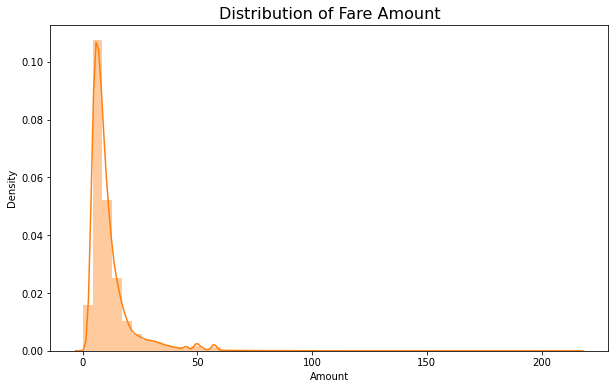

In [12]:
# target value examination
col = sns.color_palette()
plt.figure(figsize = (10, 6))
sns.distplot(sample_training['fare_amount'], color = col[1])

plt.title(
    'Distribution of Fare Amount', fontdict={'fontsize': 16})
plt.xlabel('Amount')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

Let's check for outliers, negative values, null values or to big values

In [13]:
fare_amount = sample_training['fare_amount']
print(f"There are {len(fare_amount[fare_amount<0])} negative values")
print(f"There are {len(fare_amount[fare_amount==0])} null values")
print(f"There are {len(fare_amount[fare_amount>100])} unreasanable values")

There are 0 negative values
There are 5 null values
There are 33 unreasanable values


We will remove all the values between (2.5 and 100) for the Fare amount.

In [14]:
sample_training = sample_training[sample_training['fare_amount'].between(left = 2.5, right = 100)]

## Passenger count

Let's take a look at **passenger count distribution**.

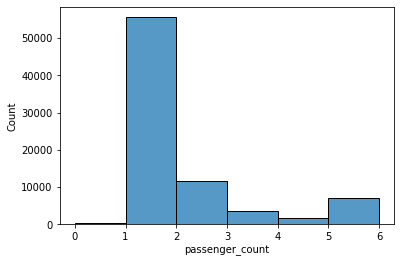

In [15]:
sns.histplot(data=sample_training, x="passenger_count", binwidth=1)
plt.show()

Fot the **passenger_count** we will remove any values between (1 and 6)

In [16]:
sample_training = sample_training[sample_training['passenger_count'].between(left = 1, right = 6)]

## Longitudes and Latitides
For these columns we'll simply trim the data keeping values between 2.5 percentile and 97.5 percentile

In [17]:
for col in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']:

    low = sample_training[col].quantile(.025)
    high = sample_training[col].quantile(.975)
    
    sample_training = sample_training[sample_training[col].between(left = low, right = high)]

## Time variables

Let's see The distribution of the pickups by year

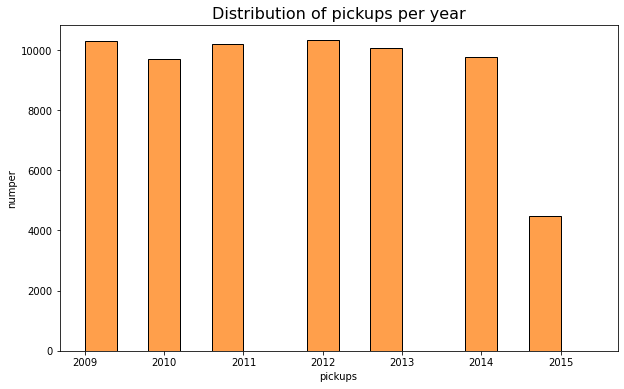

In [18]:
col = sns.color_palette()
plt.figure(figsize = (10, 6))
sns.histplot(sample_training['pickup_year'], binwidth = .4, color = col[1])

plt.title(
    'Distribution of pickups per year', fontdict={'fontsize': 16})
plt.xlabel('pickups')
plt.ylabel('numper')
plt.legend().remove()
plt.show()

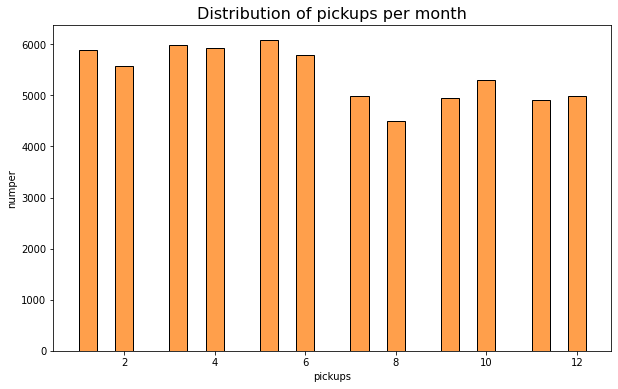

In [19]:
col = sns.color_palette()
plt.figure(figsize = (10, 6))
sns.histplot(sample_training['pickup_month'], binwidth = .4, color = col[1])

plt.title(
    'Distribution of pickups per month', fontdict={'fontsize': 16})
plt.xlabel('pickups')
plt.ylabel('numper')
plt.legend().remove()
plt.show()

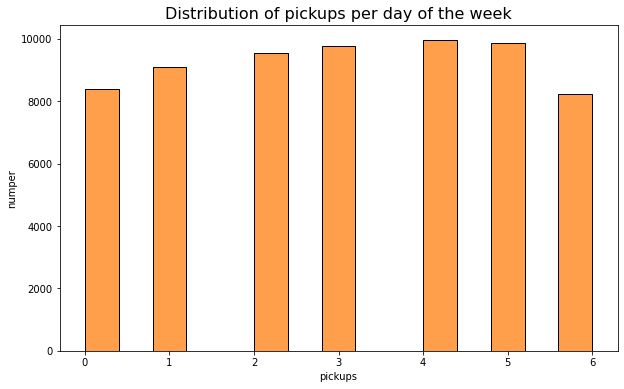

In [20]:
col = sns.color_palette()
plt.figure(figsize = (10, 6))
sns.histplot(sample_training['pickup_day_of_week'], binwidth = .4, color = col[1])

plt.title(
    'Distribution of pickups per day of the week', fontdict={'fontsize': 16})
plt.xlabel('pickups')
plt.ylabel('numper')
plt.legend().remove()
plt.show()

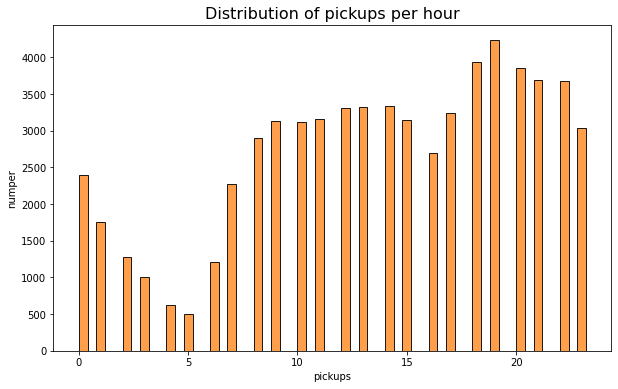

In [21]:
col = sns.color_palette()
plt.figure(figsize = (10, 6))
sns.histplot(sample_training['pickup_hour'], binwidth = .4, color = col[1])

plt.title(
    'Distribution of pickups per hour', fontdict={'fontsize': 16})
plt.xlabel('pickups')
plt.ylabel('numper')
plt.legend().remove()
plt.show()

# Plotting the spacial data

In [22]:
pickup_locs = sample_training[['pickup_longitude', 'pickup_latitude']]
pickup_locs = pickup_locs[(pickup_locs['pickup_latitude'] > -90) & (pickup_locs['pickup_latitude'] < 90) & (pickup_locs['pickup_longitude'] > -180) & (pickup_locs['pickup_longitude'] < 180)]
dropoff_locs = sample_training[['dropoff_longitude', 'dropoff_latitude']]
dropoff_locs = dropoff_locs[(dropoff_locs['dropoff_latitude'] > -90) & (dropoff_locs['dropoff_latitude'] < 90) & (dropoff_locs['dropoff_longitude'] > -180) & (dropoff_locs['dropoff_longitude'] < 180)]


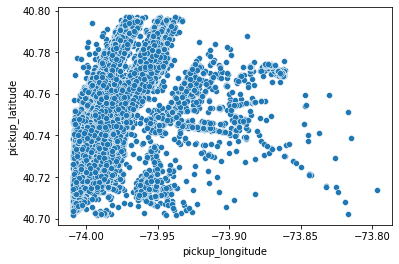

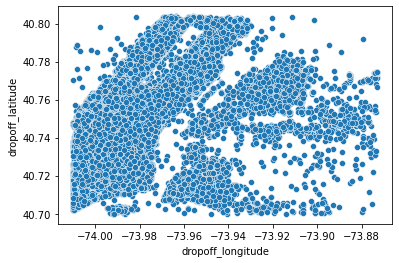

In [23]:
pickup_locs = sample_training[['pickup_longitude', 'pickup_latitude']]
sns.scatterplot(data = pickup_locs, x = 'pickup_longitude', y = 'pickup_latitude')
plt.show()

dropoff_locs = sample_training[['dropoff_longitude', 'dropoff_latitude']]
sns.scatterplot(data = dropoff_locs, x = 'dropoff_longitude', y = 'dropoff_latitude')
plt.show()

In [24]:
import pathlib
import geopandas as gpd
import folium
from folium import plugins


coord_list_pickup = [(x, y) for x, y in zip(pickup_locs.pickup_latitude, pickup_locs.pickup_longitude)]

m = folium.Map(location = (40.75, -73.94), zoom_start = 12)

plugins.HeatMap(coord_list_pickup,radius = 3, blur = 2).add_to(m)
m

In [25]:
coord_list_drop_off = [(x, y) for x, y in zip(dropoff_locs.dropoff_latitude, dropoff_locs.dropoff_longitude)]

m = folium.Map(location = (40.75, -73.94), zoom_start = 12)
# folium.GeoJson(data=gdf["geometry"]).add_to(m)
plugins.HeatMap(coord_list_drop_off,radius = 3, blur = 2).add_to(m)
m

# Feature Engeniering

Defining and **euclidean_distance** and **haversine_distance**.

In [26]:
def euclidean_distance(pickup, dropoff):
    return np.sqrt(np.power(dropoff[0]-pickup[0], 2) + np.power(dropoff[1]-pickup[1], 2))

In [27]:
def haversine_distance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    earth_radius = 6371
    
    # converting degrees to radians
    pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude = map(np.radians,
                                                             [pickup_longitude, pickup_latitude, 
                                                              dropoff_longitude, dropoff_latitude])
    
    delta_longitude = dropoff_longitude - pickup_longitude
    delta_latitude = dropoff_latitude - pickup_latitude
    root = np.sin(delta_latitude/2)**2 + np.cos(dropoff_latitude)*np.cos(pickup_latitude)*np.sin(delta_longitude/2)**2
    dist = earth_radius*2*np.arcsin(np.sqrt(root))
    return round(dist, 2)
    

In [28]:
# feature engeniering
sample_training = training.copy()
sample_training.fillna(0, inplace=True)

# date columns parsing
date_format = "%Y-%m-%d %H:%M:%S"
date_format = "%Y-%m-%d %H:%M:%S UTC"
base_date = datetime.strptime("2009-06-15 17:26:21 UTC", date_format)

sample_training['pickup_datetime'] = pd.to_datetime(sample_training['pickup_datetime'], format=date_format)

# let's add a year month day hour columns

sample_training['pickup_year'] = sample_training['pickup_datetime'].apply(lambda x: x.year)
sample_training['pickup_month'] = sample_training['pickup_datetime'].apply(lambda x: x.month)
sample_training['pickup_day_of_week'] = sample_training['pickup_datetime'].apply(lambda x: x.weekday())
sample_training['pickup_hour'] = sample_training['pickup_datetime'].apply(lambda x: x.hour)

# Absolute difference in latitude and longitude
sample_training['abs_lat_diff'] = (sample_training['dropoff_latitude'] - sample_training['pickup_latitude']).abs()
sample_training['abs_lon_diff'] = (sample_training['dropoff_longitude'] - sample_training['pickup_longitude']).abs()

# Haversine distance
sample_training['hav_dist'] = sample_training[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(lambda x:haversine_distance(x[0], x[1], x[2], x[3])
                                              , axis = 1)

In [29]:
temp = sample_training[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
sample_training['euclidean_dis'] = temp.apply(lambda x:euclidean_distance((x[0], x[1]), (x[2], x[3]))
                                              , axis = 1)


In [30]:
sample_training.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day_of_week,pickup_hour,abs_lat_diff,abs_lon_diff,hav_dist,euclidean_dis
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.009041,0.002701,1.03,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,0.070701,0.036780,8.45,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.010708,0.008504,1.39,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,0.024949,0.004437,2.80,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,0.015754,0.011440,2.00,0.019470


# Basic Modeling
In this section we'll try some simple solutions like Decision trees and linear regression.

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# preprocessing the data
sample_training = pipe_line(training)

Let's split the train and the test sets

In [32]:
X = sample_training[[
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                     'passenger_count',
                     'pickup_year', 'pickup_month', 'pickup_day_of_week', 'pickup_hour', 
                     'abs_lat_diff', 'abs_lon_diff', 'euclidean_dis', 'hav_dist', 'jfk_dist', 'lga_dist',
                     'ewr_dist', 'tsq_dist']]
y = sample_training['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

### Linear Regression

In [33]:
lr = LinearRegression()
cv = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(cv)
print(cv.mean())

[-3.23685705 -3.24779653 -3.21852141 -3.18383762 -3.26488114]
-3.230378749332954


### Lasso Method

In [34]:
lasso = Lasso()
cv = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(cv)
print(cv.mean())

[-3.51406727 -3.52139371 -3.49903698 -3.47119127 -3.54004552]
-3.509146951574543


### Random Forest

In [35]:
rf = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)
cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(cv)
print(cv.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 o

[-2.92846895 -2.94310738 -2.93538271 -2.8962287  -2.96159841]
-2.9329572304364495


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


## Results for our Basic modeling
| Model | RMSE score |
| --- | --- |
| Linear Regression | 3.23 |
| Lasso | 3.50 |
| Random Forest | 2.93 |


# Advaced Modeling
The Random Forest Model performed pretty well, but we will use the more sophisticated modes XG-Boost and LightGBM with hyper parameter tuning.

# Ligth-GBM

In [36]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import metrics

In [37]:
from sklearn.metrics import mean_squared_error

def custom_metric(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse

In [38]:
import lightgbm as lgbm

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }


space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

def objective(space):
    train_set = lgbm.Dataset(X_train, y_train, silent=False,categorical_feature=['pickup_year','pickup_month','pickup_day_of_week','pickup_hour'])
    valid_set = lgbm.Dataset(X_test, y_test, silent=False,categorical_feature=['pickup_year','pickup_month','pickup_day_of_week','pickup_hour'])
    model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)


    y_pred = model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred, squared=False)

    return {'loss': loss, 'status': STATUS_OK }

print(objective(space))

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 2.83728
[1000]	valid_0's rmse: 2.81644
[1500]	valid_0's rmse: 2.80491
[2000]	valid_0's rmse: 2.80004
[2500]	valid_0's rmse: 2.79806
[3000]	valid_0's rmse: 2.79819
Early stopping, best iteration is:
[2557]	valid_0's rmse: 2.79778
{'loss': 2.7977800604568976, 'status': 'ok'}


# XG-Boost

In [39]:
from xgboost import XGBRegressor

space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

def objective(space):
    xg_boost = XGBRegressor(boosting_type = space['boosting_type'], limit_max_depth = space['limit_max_depth'], max_depth= int(space['max_depth']),
                            num_leaves = space['num_leaves'], learning_rate = space['learning_rate'], subsample_for_bin = space['subsample_for_bin'],
                            min_child_samples = space['min_child_samples'], reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'],
                            colsample_bytree = space['colsample_bytree'])

    xg_boost.fit(X_train, y_train, verbose=False)

    y_pred = xg_boost.predict(X_test)
    loss = mean_squared_error(y_test, y_pred, squared=False)

    return {'loss': loss, 'status': STATUS_OK }

    
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = Trials(),
                       )

[20:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100%|██████████| 5/5 [45:35<00:00, 547.11s/it, best loss: 2.9237160081351043]


The results for The advanced models are:

| Model | RMSE score |
| --- | --- |
| Light-GBM | 2.79 |
| XG-Boost | 2.92 |

# Results
The Project goal was to improve the score of the simple calculations, the best results that we got are **2.79** for **Light-GBM**, **2.92** for **XG-Boost*, and **2.93** for **Random Forest**, this is a big improvment compared to the **5-8 RMSE** of the initial solution.